# Customer Churn Prediction

Customer churn, also known as customer attrition, refers to the phenomenon where customers stop doing business with a company. Predicting customer churn is crucial for businesses as acquiring new customers is often more expensive than retaining existing ones.

This notebook aims to analyze customer data to understand the factors contributing to churn and build a machine learning model to predict which customers are likely to churn in the future.

In [15]:
import pandas as pd

# Load datasets
df_train = pd.read_csv("customer_churn_dataset-training-master.csv")
df_test = pd.read_csv("customer_churn_dataset-testing-master.csv")

# Display the first few rows
df_train.head()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


In [ ]:
print("Missing values in training data:")
print(df_train.isnull().sum())

CustomerID           1
Age                  1
Gender               1
Tenure               1
Usage Frequency      1
Support Calls        1
Payment Delay        1
Subscription Type    1
Contract Length      1
Total Spend          1
Last Interaction     1
Churn                1
dtype: int64


### Data Summary
Get a concise summary of the dataframe, including data types and non-null counts.

In [ ]:
print("\nTraining data info:")
df_train.info()

In [ ]:
# Handle potential missing values (Example: Fill with median or mean if necessary)
# For now, we observe very few missing values, often just one row.
# Let's drop rows with any missing values for simplicity in this example.
df_train.dropna(inplace=True)
print("\nMissing values after handling:")
print(df_train.isnull().sum())

In [ ]:
print("\nDescriptive Statistics:")
print(df_train.describe())

          CustomerID            Age         Tenure  Usage Frequency  \
count  440832.000000  440832.000000  440832.000000    440832.000000   
mean   225398.667955      39.373153      31.256336        15.807494   
std    129531.918550      12.442369      17.255727         8.586242   
min         2.000000      18.000000       1.000000         1.000000   
25%    113621.750000      29.000000      16.000000         9.000000   
50%    226125.500000      39.000000      32.000000        16.000000   
75%    337739.250000      48.000000      46.000000        23.000000   
max    449999.000000      65.000000      60.000000        30.000000   

       Support Calls  Payment Delay    Total Spend  Last Interaction  \
count  440832.000000  440832.000000  440832.000000     440832.000000   
mean        3.604437      12.965722     631.616223         14.480868   
std         3.070218       8.258063     240.803001          8.596208   
min         0.000000       0.000000     100.000000          1.000000   


### Data Visualization

In [ ]:
# Calculate the percentage of churn distribution
churn_percentage = df_train['Churn'].value_counts(normalize=True) * 100
print("\nChurn Distribution (%):")
print(churn_percentage)

Churn
1.0    56.71072
0.0    43.28928
Name: proportion, dtype: float64

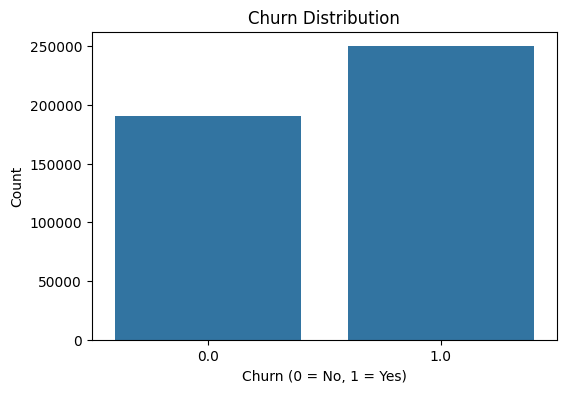

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=df_train)
plt.title("Churn Distribution")
plt.xlabel("Churn (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

#### Numerical Feature Distributions

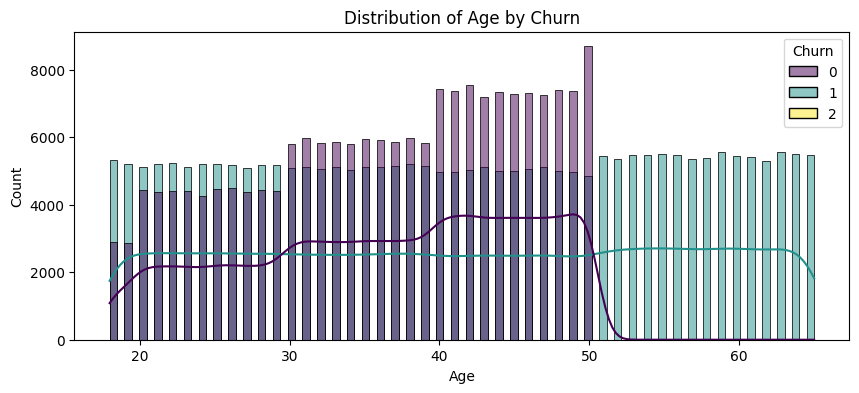

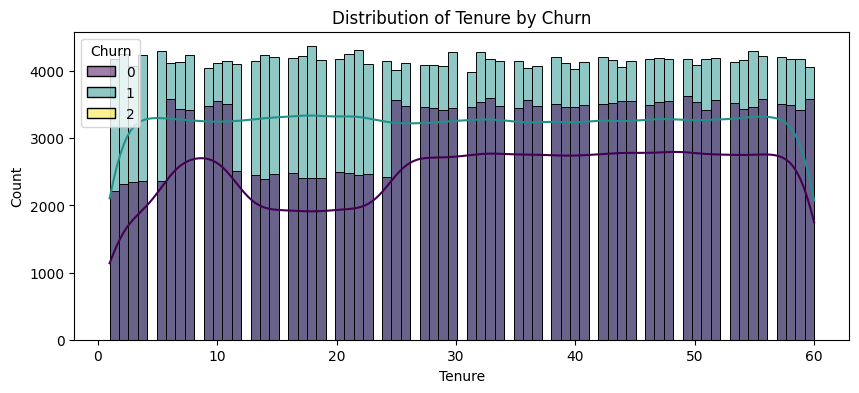

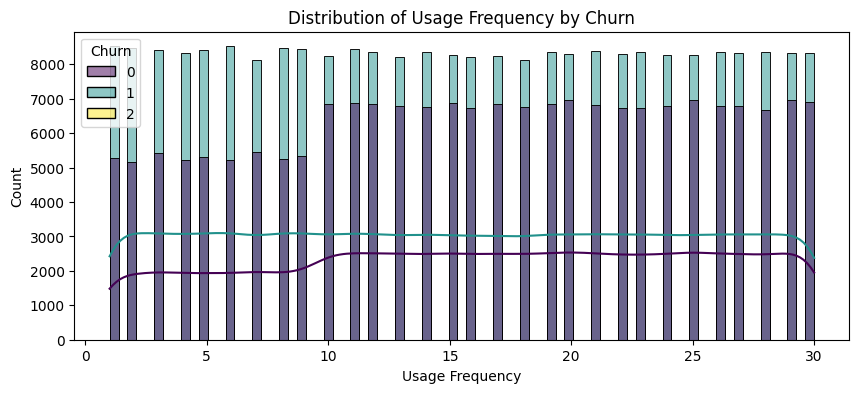

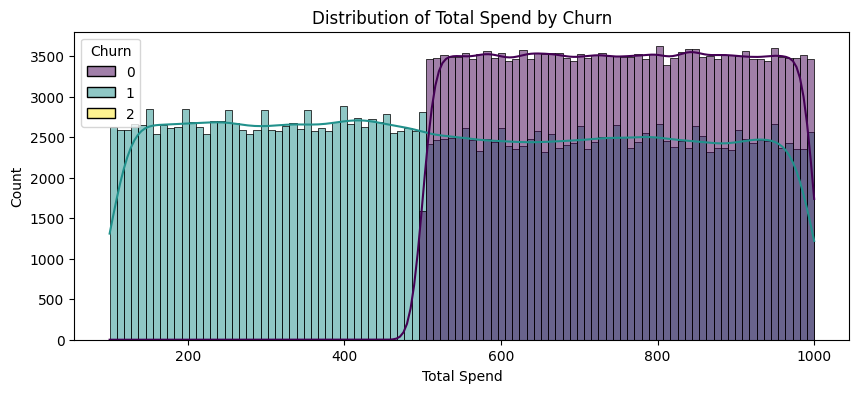

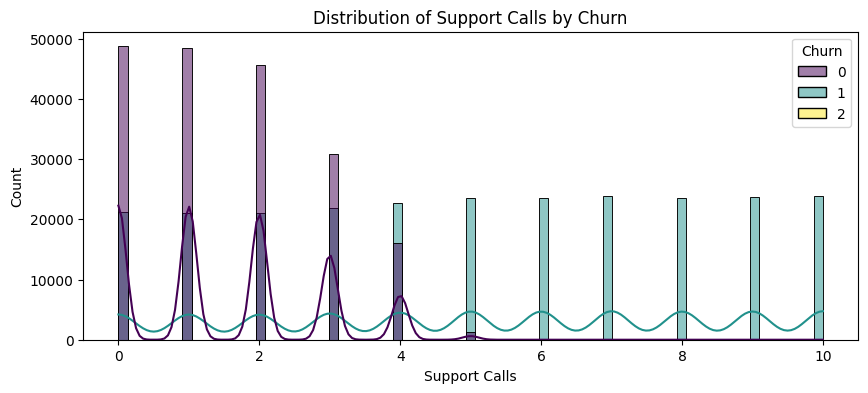

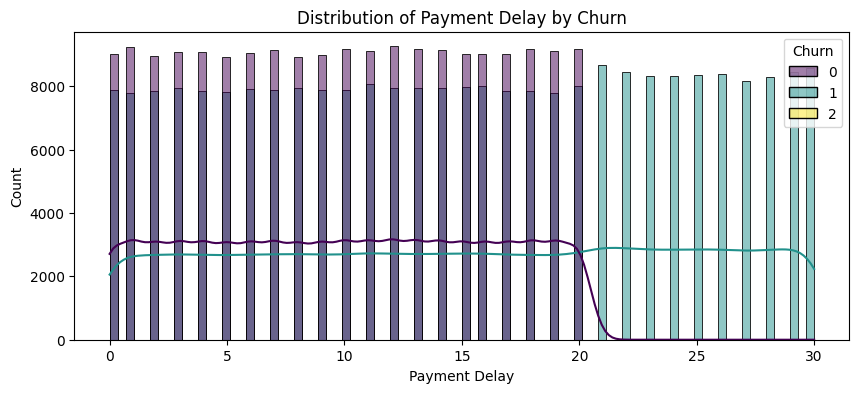

In [32]:
numerical_features = ['Age', 'Tenure', 'Usage Frequency', 'Total Spend', 'Support Calls', 'Payment Delay']

for feature in numerical_features:
    plt.figure(figsize=(10, 4))
    sns.histplot(data=df_train, x=feature, kde=True, hue='Churn', palette='viridis')
    plt.title(f'Distribution of {feature} by Churn')
    plt.show()

#### Categorical Feature Distributions

In [ ]:
categorical_features = ['Gender', 'Subscription Type', 'Contract Length']

for feature in categorical_features:
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df_train, x=feature, hue='Churn', palette='muted')
    plt.title(f'{feature} Distribution by Churn')
    plt.xticks(rotation=45)
    plt.show()

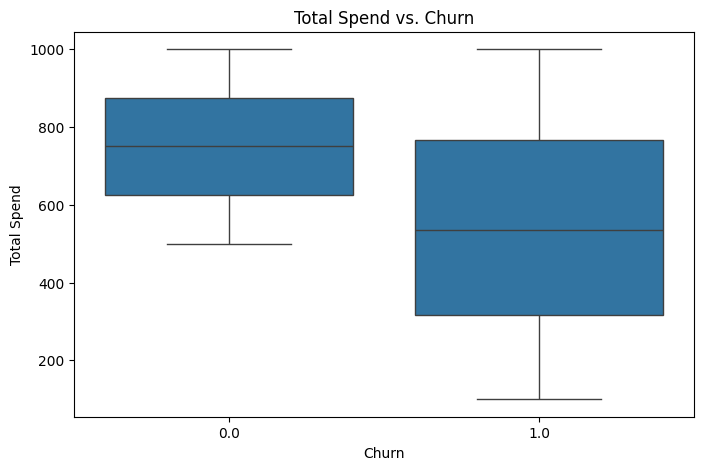

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(x="Churn", y="Total Spend", data=df_train, palette='coolwarm')
plt.title("Total Spend vs. Churn")
plt.show()


### Feature Correlation

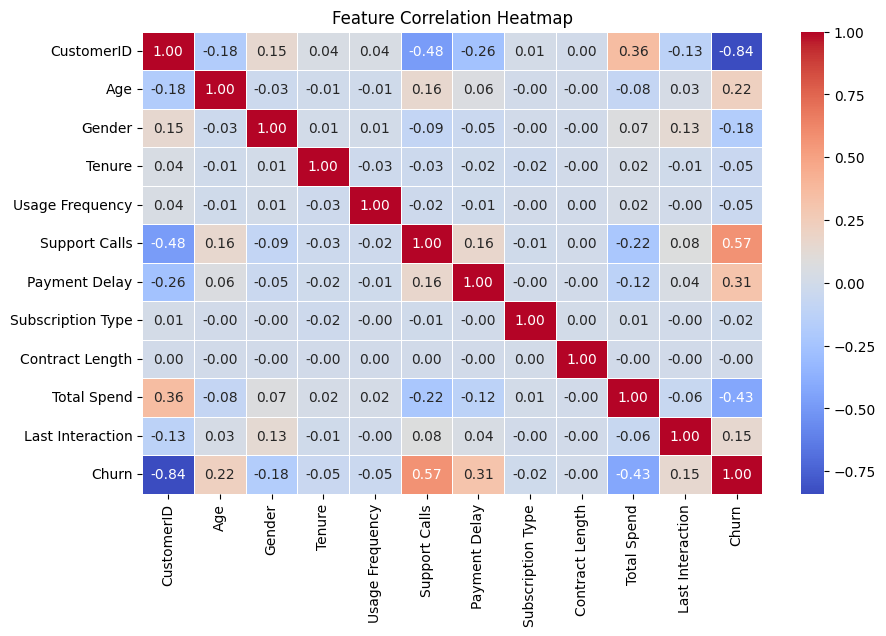

In [ ]:
# Strip spaces from column names
df_train.columns = df_train.columns.str.strip()

# Convert categorical variables into numeric for correlation calculation
df_train_encoded = df_train.copy()

# Encode categorical columns using Label Encoding
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
categorical_cols = ["Gender", "Subscription Type", "Contract Length"]
for col in categorical_cols:
    df_train_encoded[col] = encoder.fit_transform(df_train_encoded[col])

# Ensure 'Churn' is numeric (it should be already after dropna and initial load)
if df_train_encoded["Churn"].dtype == "object":
    df_train_encoded["Churn"] = encoder.fit_transform(df_train_encoded["Churn"])

# q2) Compute correlation matrix
correlation_matrix = df_train_encoded.corr()

# Plot heatmap
plt.figure(figsize=(12, 8)) # Increased size for better readability
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

### Data Preprocessing for Modeling

In [ ]:
# We already handled missing values and ensured Churn is numeric.
# Now, apply one-hot encoding to categorical features for the model.
# Note: We use the original df_train here, not df_train_encoded which was just for correlation.

# Ensure Churn is integer type if it's not already
if df_train['Churn'].dtype != 'int64':
   df_train['Churn'] = df_train['Churn'].astype(int)

df_train = pd.get_dummies(df_train, columns=categorical_cols, drop_first=True)

In [23]:
from sklearn.model_selection import train_test_split

X = df_train.drop(columns=["Churn", "CustomerID"])
y = df_train["Churn"]
# q3) Split the dataset into training and validation sets, with 80% for training and 20% for validation and random_state=42
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
from sklearn.ensemble import RandomForestClassifier

# q4) Train a Random Forest Classifier with 100 trees and random state 42
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [31]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print(f"Model Accuracy: {accuracy:.6f}")

Model Accuracy: 0.999535


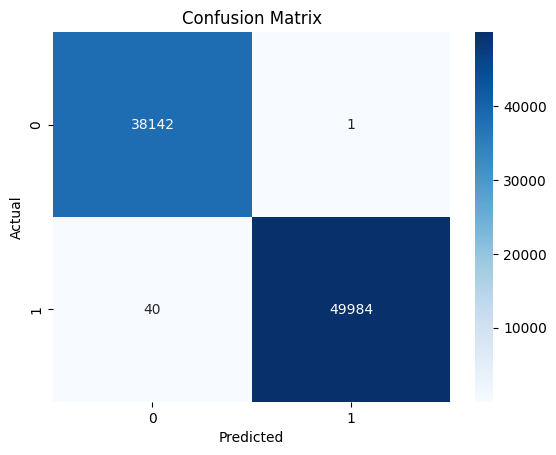

In [26]:
from sklearn.metrics import confusion_matrix, classification_report

conf_matrix = confusion_matrix(y_val, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
# q5) Print classification report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     38143
           1       1.00      1.00      1.00     50024

    accuracy                           1.00     88167
   macro avg       1.00      1.00      1.00     88167
weighted avg       1.00      1.00      1.00     88167



### ROC Curve and AUC Score

The ROC curve plots the True Positive Rate against the False Positive Rate at various threshold settings. The AUC score represents the model's ability to distinguish between positive and negative classes.

AUC Score: 1.0000


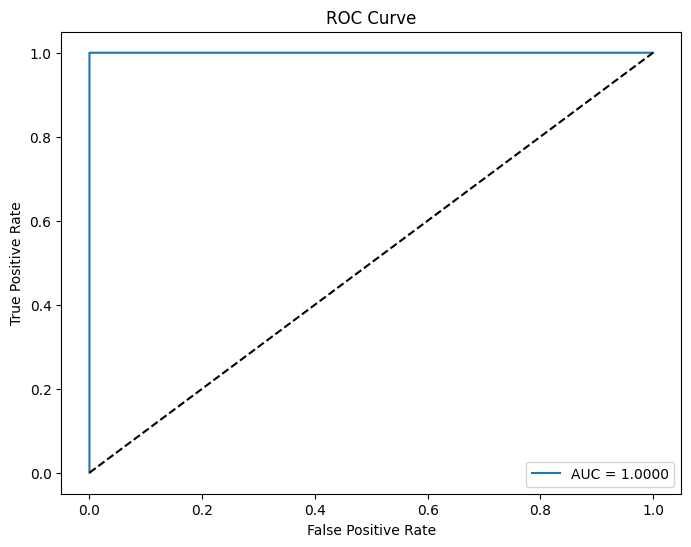

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# Get predicted probabilities for the positive class
y_pred_proba = model.predict_proba(X_val)[:, 1]

# q6) Calculate ROC curve
# ROC curve is used to evaluate the performance of a binary classifier
# It plots the true positive rate (sensitivity) against the false positive rate (1-specificity)
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

# Calculate AUC score , it means Area Under the Curve
# AUC score is a single scalar value that summarizes the performance of the model
auc_score = roc_auc_score(y_val, y_pred_proba)
print(f"AUC Score: {auc_score:.4f}")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

### Feature Importance

Let's examine which features the RandomForest model found most important for predicting churn.

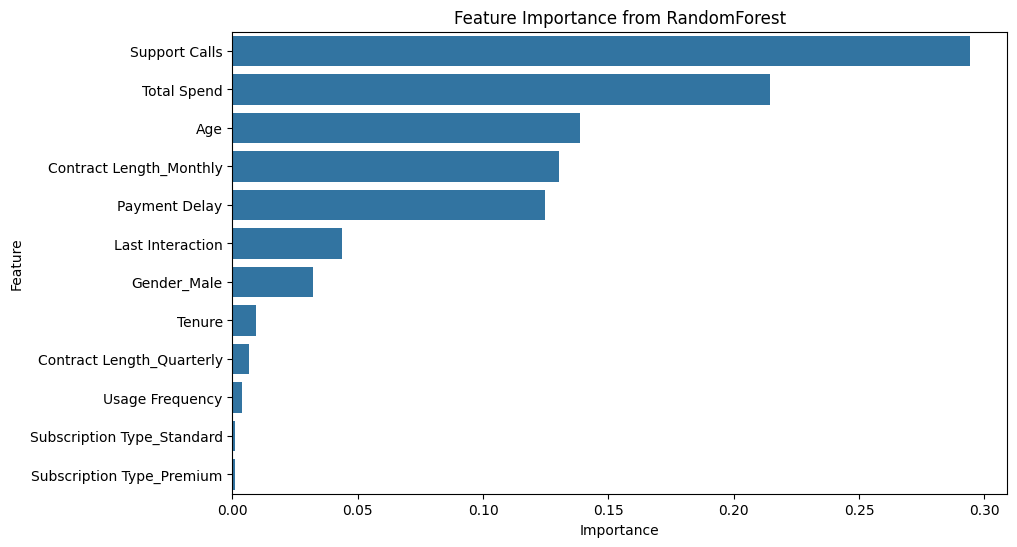

In [ ]:
import numpy as np

feature_importances = model.feature_importances_
features = X_train.columns

importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
# q7) Sort the features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance from RandomForest')
plt.show()